In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from softmax_regression import SoftmaxRegression
from utils import (
    get_gaussians,
    get_PU_labels,
    show_label_partition,
    fit_plot
)
%matplotlib inline

### Class dependent loss

In [17]:
class PUSoftmaxRegression(SoftmaxRegression):
    def __init__(self, a=1., r=3,
                 eta=0.01, epochs=100,
                 l2=0.0,
                 minibatches=1,
                 n_classes=None,
                 class_weight=None,
                 random_seed=None):
        super(PUSoftmaxRegression, self).__init__(eta, epochs,
                                                  l2, minibatches,
                                                  n_classes,
                                                  class_weight,
                                                  random_seed)
        self.a_ = float(a)
        self.r_ = float(r)

    def _loss(self, prob, y_enc):
        post = self._posterior(prob)
        loss = self._cross_entropy(post, y_enc)
        loss = np.sum(loss, axis=1)
        return loss
    
    def _diff(self, prob, y_enc):
        post = self._posterior(prob)
        diff = (prob - y_enc) / (self.r_ + 1)
        # unlabelled
        unl_idx = np.where(y_enc[:, 0])[0]
        ratio = 1 / ((post[unl_idx, 0] * (self.r_ + 1)))
        dldp = - prob[unl_idx, 1] \
                     / np.power(prob[unl_idx, 1], self.r_ / (self.r_ + 1))
        diff[unl_idx, 0] = ratio * dldp * (prob[unl_idx, 0] - 0)
        diff[unl_idx, 1] = ratio * dldp * (prob[unl_idx, 1] - 1)
        return diff
    
    def _posterior(self, prob):
        post = np.power(prob, 1 / (self.r_ + 1))
        post[:, 0] = 1 - np.sum(post[:, 1:], axis=1)
        return post
    
    def predict_proba(self, X):
        net = self._net_input(X, self.w_, self.b_)
        prob = self._softmax(net)
        post = self._posterior(prob)
        return post
    
    def _cross_entropy(self, q, p):
        q = q.clip(min=1e-16)
        return - (p) * np.log(q)


    
class ClassDepLossSoftmaxRegression(SoftmaxRegression):
    """Class dependent loss SoftmaxRegression."""

    def __init__(self, eta=0.01, epochs=100,
                 l2=0.0,
                 minibatches=1,
                 n_classes=None,
                 class_weight=None,
                 unbalanced=None,
                 random_seed=None):
        """Init."""
        super(ClassDepLossSoftmaxRegression, self).__init__(eta, epochs,
                                                            l2,
                                                            minibatches,
                                                            n_classes,
                                                            class_weight,
                                                            unbalanced,
                                                            random_seed)

    def _loss(self, prob, y_enc):
        loss = self._cross_entropy(prob, y_enc)
        negidx = np.where(y_enc[:, 0])[0]
        loss[negidx, :] = 0   # redundant
        loss[negidx, 0] = (1 - prob[negidx, 0])
        loss = np.sum(loss, axis=1)
        if self.class_weight is not None:
            sample_weights = self._get_sample_weights(y_enc, tiled=False)
            loss = loss * sample_weights
        return loss

    def _diff(self, prob, y_enc):
        diff = prob - y_enc
        negidx = np.where(y_enc[:, 0])[0]
        for cl in range(self.n_classes):
            if cl == 0:
                diff[negidx, cl] = prob[negidx, 0] * (prob[negidx, cl] - 1)
            else:
                diff[negidx, cl] = prob[negidx, 0] * prob[negidx, cl]
        if self.class_weight is not None:
            sample_weights = self._get_sample_weights(y_enc, tiled=True)
            diff = diff * sample_weights
        return diff

class TranslatedSoftmaxRegression(SoftmaxRegression):
    def __init__(self, translate=[5, 0], eta=0.01, epochs=100,
                 l2=0.0,
                 minibatches=1,
                 n_classes=None,
                 random_seed=None):
        super(TranslatedSoftmaxRegression, self).__init__(eta, epochs,
                                                         l2, minibatches,
                                                         n_classes,
                                                         random_seed)
        self.translate = np.array(translate)

    def _softmax(self, z):
        z = z.copy().astype('float64')
        z -= self.translate
        z -= np.max(z, axis=1, keepdims=True)  # stable softmax
        return (np.exp(z.T) / np.sum(np.exp(z), axis=1)).T

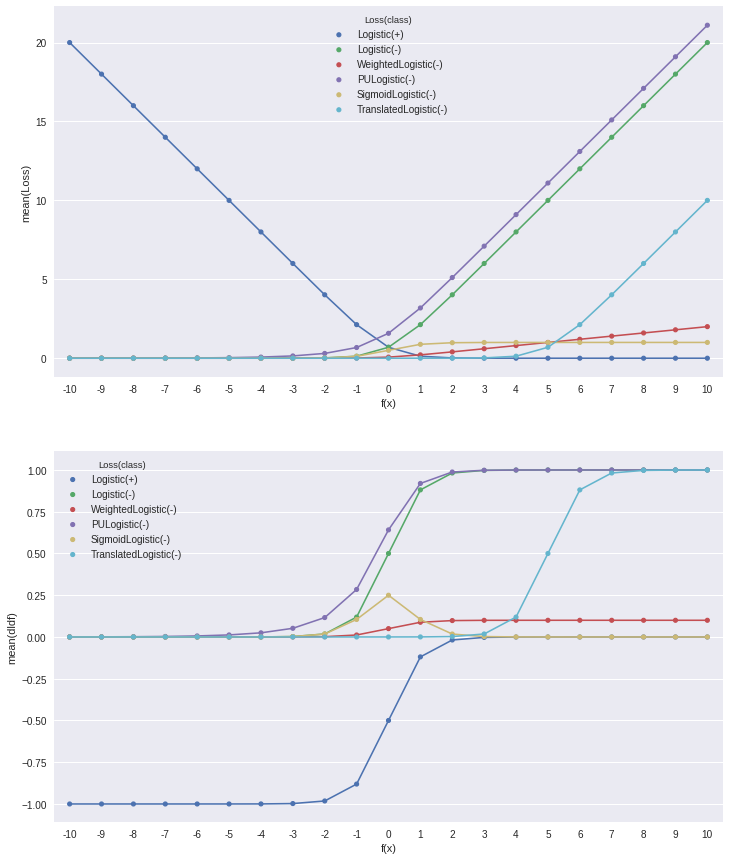

In [18]:
import seaborn as sns
import pandas as pd

x = np.arange(-10, 11, 1)
x = np.vstack([-x, x]).T

y_pos = np.zeros((21, 2)).astype('int8')
y_pos[:, 1] = 1
y_neg = np.zeros((21, 2)).astype('int8')
y_neg[:, 0] = 1

softreg = SoftmaxRegression(n_classes=2)
prob = softreg._softmax(x.copy())
loss = softreg._loss(prob, y_pos)           # y=+1
diff = softreg._diff(prob, y_pos)           # dldf
df1 = pd.DataFrame({'f(x)': x[:, 1], 'Loss': loss, 'dldf': diff[: ,1], 'Loss(class)':'Logistic(+)'})
loss = softreg._loss(prob, y_neg)           # y=-1
diff = softreg._diff(prob, y_neg)           # dldf
df2 = pd.DataFrame({'f(x)': x[:, 1], 'Loss': loss, 'dldf': diff[:, 1], 'Loss(class)':'Logistic(-)'})

wtd_softreg = SoftmaxRegression(class_weight=(0.1, 1), n_classes=2)
loss = wtd_softreg._loss(prob, y_neg)           # y=-1
diff = wtd_softreg._diff(prob, y_neg)           # dldf
df3 = pd.DataFrame({'f(x)': x[:, 1], 'Loss': loss, 'dldf': diff[:, 1], 'Loss(class)':'WeightedLogistic(-)'})

pu_softreg = PUSoftmaxRegression(a=1., r=2, n_classes=2)
loss = pu_softreg._loss(prob, y_neg)           # y=-1
diff = pu_softreg._diff(prob, y_neg)           # dldf
df4 = pd.DataFrame({'f(x)': x[:, 1], 'Loss': loss, 'dldf': diff[:, 1], 'Loss(class)':'PULogistic(-)'})

sig_softreg = ClassDepLossSoftmaxRegression(n_classes=2)
loss = sig_softreg._loss(prob, y_neg)           # y=-1
diff = sig_softreg._diff(prob, y_neg)           # dldf
df5 = pd.DataFrame({'f(x)': x[:, 1], 'Loss': loss, 'dldf': diff[:, 1], 'Loss(class)':'SigmoidLogistic(-)'})

trans_softreg = TranslatedSoftmaxRegression(translate=(0, 10))
prob = trans_softreg._softmax(x.copy())
loss = trans_softreg._loss(prob, y_neg)           # y=-1
diff = trans_softreg._diff(prob, y_neg)           # dldf
df6 = pd.DataFrame({'f(x)': x[:, 1], 'Loss': loss, 'dldf': diff[:, 1], 'Loss(class)':'TranslatedLogistic(-)'})

# ln_delta = np.exp(-np.power(x[:, 1], 2))
# dn_delta = np.exp(-np.power(x[:, 1], 2)) * x[:, 1] * 2
# df6 = pd.DataFrame({'f(x)': x[:, 1], 'Loss': ln_delta, 'dldf': dn_delta, 'Loss(class)':'Delta(-)'})

# r = 5
# l_lbl = - np.log(np.power(p, 1)) / (r + 1)
# l_unl = - np.log((1 - np.power(p, 1/(r+1))))
# ln_pu = l_unl
# dn_pu = l_unl
# df7 = pd.DataFrame({'f(x)': x[:, 1], 'Loss': ln_pu, 'dldf': dn_pu, 'Loss(class)':'Unlabelled(-)'})
# plt.plot(p, l_lbl)
# plt.plot(p, l_unl)

f, axes = plt.subplots(2, figsize=(12, 15))
sns.pointplot(x='f(x)', y='Loss', hue='Loss(class)', data=pd.concat([df1, df2, df3, df4, df5, df6]),
                scale=0.5, ax=axes[0])
sns.pointplot(x='f(x)', y='dldf', hue='Loss(class)', data=pd.concat([df1, df2, df3, df4, df5, df6]),
                scale=0.5, ax=axes[1])

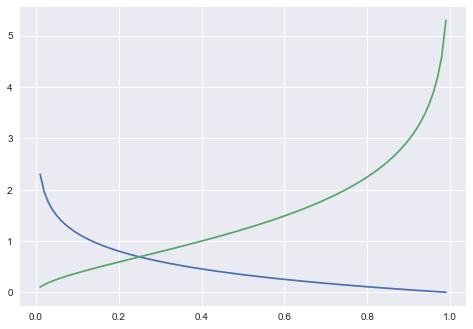

In [58]:
r = 1.
x = np.arange(0.01, 1., 0.01)
p = - np.log(x) / (r+1)
u = - np.log(1 - np.power(x, 1/(r+1)))
plt.plot(x, p)
plt.plot(x, u)

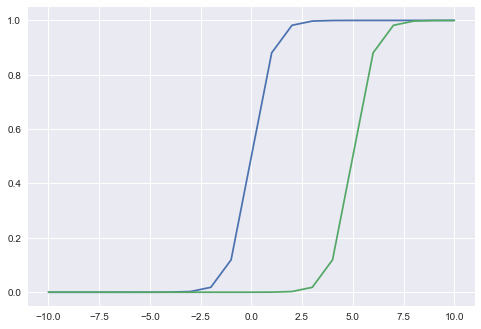

In [138]:
softreg = SoftmaxRegression(n_classes=2)
prob = softreg._softmax(x.copy())
plt.plot(x[:, 1], prob[:,1])

trans_softreg = TranslatedSoftmaxRegression(translate=(0, 10),n_classes=2)
prob = trans_softreg._softmax(x.copy())
plt.plot(x[:, 1], prob[:,1])

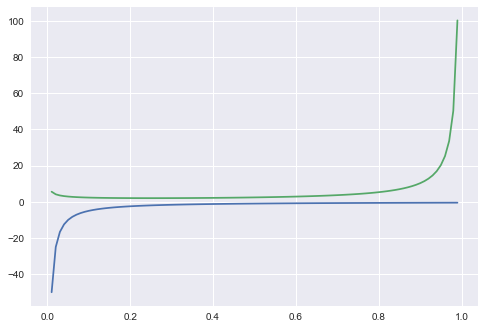

In [61]:
dp = - 1 / ((r+1)*x)
du = 1 / ((1 - np.power(x, 1/(r+1))) * (r+1) * np.power(x, r/(r+1)))
plt.plot(x, dp)
plt.plot(x, du)

### Class weight Softmax Loss

\begin{equation}
L= \sum_{i} -\beta_{y} \ln p_{y}^{(i)}
\end{equation}

Positive (beta=0.0): 100  vs. 100
Positive (beta=0.1): 100  vs. 88
Positive (beta=0.2): 100  vs. 76
Positive (beta=0.30000000000000004): 100  vs. 64
Positive (beta=0.4): 100  vs. 53
Positive (beta=0.5): 100  vs. 48
Positive (beta=0.6000000000000001): 100  vs. 33
Positive (beta=0.7000000000000001): 100  vs. 29
Positive (beta=0.8): 100  vs. 22
Positive (beta=0.9): 100  vs. 12
Positive (beta=1.0): 100  vs. 0


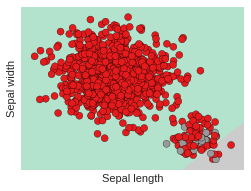

Loss: 0.0294013532993


In [40]:
# Number of samples per component
n_samples = 1000
# Percentage of test samples
pct_positive = 0.1
# Generate random sample, two components
random_seed = 0
X, Y = get_gaussians(n_samples, pct_positive, distance=3, random_seed=random_seed)
betas = np.arange(0., 1+1e-8, 0.1)
Y_pus = get_PU_labels(Y, betas, random_seed=random_seed)
np.random.seed(None)
pu_softreg = PUSoftmaxRegression(r=3,
                                 minibatches=1,
                                 eta=1e-3, l2=1e-5,
                                 epochs=200,
                                 random_seed=None)
fit_plot(X, Y_pus[8][1], fit_classifier=pu_softreg)
print('Loss:', pu_softreg.cost_[-1])

### Selective Asymmetric

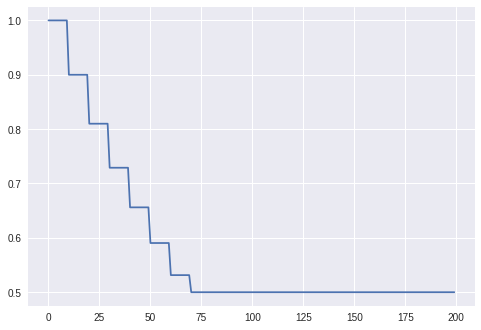

In [8]:
# # sigmoid
# i_ = np.arange(1000)
# thresh_ = 0.8
# decay_ =  1 / ( 1 + np.exp( (i_ - max(i_)/2) / (max(i_)/10)))
# t_ = (1 - thresh_) * decay_ + thresh_
# plt.plot(i_, t_)
# plt.show()

# step
epochs = 200
i_ = np.arange(epochs)
lambda_ = 0.9
step_ = 10
min_ = 0.5

t_ = np.power(lambda_, i_ // step_)
t_ = t_.clip(min=min_)

# # increasing lambda
# i_ = np.arange(200)
# lambda_ = i_ / 200
# lambda_ = lambda_.clip(max=1-1e-8)
# t_ = 1 / (1 - lambda_)

plt.plot(i_, t_)
plt.show()

In [78]:
class SelectiveAsymmetricSoftmaxRegression(SoftmaxRegression):
    """"P, U and RN"""
    def __init__(self, betas, thresh, eta=0.01, epochs=100,
                 l2=0.0,
                 minibatches=1,
                 n_classes=None,
                 random_seed=None):
        super(SelectiveAsymmetricSoftmaxRegression, self).__init__(eta, epochs,
                                                         l2, minibatches,
                                                         n_classes,
                                                         random_seed)
        self._betas = np.array(betas)
        self._thresh = np.array(thresh)
        
    def _cost(self, prob, y_enc):
        pred = np.argmax(prob, axis=1)
        pred_enc = self._one_hot(y=pred, n_labels=self.n_classes, dtype=np.int)
        cross_ent_y = self._cross_entropy(prob, y_enc)
        cross_ent_pred = self._cross_entropy(prob, pred_enc)
        betas = self._get_betas(y_enc)
        loss = betas * cross_ent_y
        rn_idx = self._get_reliable_negatives(prob)
        loss[rn_idx, :] = pred_enc[rn_idx, :]
        loss = np.sum(loss, axis=1)
        L2_term = self.l2 * np.sum(self.w_ ** 2)
        loss = loss + L2_term
        return 0.5 * np.mean(loss)
    
    def _diff(self, prob, y_enc):
        pred = np.argmax(prob, axis=1)
        pred_enc = self._one_hot(y=pred, n_labels=self.n_classes, dtype=np.int)
        betas = self._get_betas(y_enc)
        diff = betas * (prob - y_enc)
        diff_pred = prob - pred_enc
        rn_idx = self._get_reliable_negatives(prob)
        diff[rn_idx, :] = diff_pred[rn_idx, :]
        return diff
    
    def _get_reliable_negatives(self, prob):
        t_ = np.power(self._thresh[0], self.i_ // self._thresh[1])
        t_ = t_.clip(min=self._thresh[2])
        rn_idx = np.where(prob[:, 0] > t_)[0]
        return rn_idx

    def _get_betas(self, y_enc):
        r"""Return betas per sample \beta_t of shape (N, C)."""
        label = np.argmax(y_enc, axis=1).astype('int8')
        label = label[:, np.newaxis]
        betas = self._betas[label]
        repeats = [1] * len(label.shape)
        repeats[1] = self.n_classes
        return np.tile(betas, repeats)


### Entropy Regularization

\begin{equation}
L = -\sum_{k} g_k \ln p_k
\end{equation}
\begin{equation}
g_k = \begin{cases}
\frac{p_k^{\frac{1}{1-\lambda}}}{\sum_{l=1}^{K} p_l^{\frac{1}{1-\lambda}}} &\text{If x in U}\ \\
y_k &\text{Otherwise}
\end{cases}
\end{equation}


In [79]:
class EntropyRegularizedSoftmaxRegression(SoftmaxRegression):
    def __init__(self, eta=0.01, epochs=100,
                 l2=0.0,
                 minibatches=1,
                 n_classes=None,
                 random_seed=None):
        super(EntropyRegularizedSoftmaxRegression, self).__init__(eta, epochs,
                                                         l2, minibatches,
                                                         n_classes,
                                                         random_seed)
        self._lambda = np.arange(0., 1, 1./epochs)
#         self._lambda = np.ones(epochs)
        self._lambda = self._lambda.clip(max=1-1e-8)
        
    def _cost(self, prob, y_enc):
        y_exp = self._expected_label(prob, y_enc)
        cross_entropy = self._cross_entropy(prob, y_exp)
        loss = np.sum(cross_entropy, axis=1)
        L2_term = self.l2 * np.sum(self.w_ ** 2)
        loss = loss + L2_term
        return 0.5 * np.mean(loss)
    
    def _diff(self, prob, y_enc):
        y_exp = self._expected_label(prob, y_enc)
        return prob - y_exp
    
    def _expected_label(self, prob, y_enc):
        r"""Return expected value of labels."""
        if self.i_ == 0:
            y_exp = y_enc
        else:
            # Use expected value of y for x in U
            T = 1 / (1 - self._lambda[self.i_])
            y_exp = np.power(prob, T)
            y_exp /= np.sum(prob, axis=1, keepdims=True)
            # Use y for x in P
            for idx, y in enumerate(y_enc):
                if np.argmax(y) != 0:
                    y_exp[idx, :] = y
        return y_exp

### HardBootstrapping

\begin{equation}
L = -\sum_{k} [\beta_t y_k + (1 - \beta_t) \hat{y_k}] \ln p_k
\end{equation}

In [80]:
class HardBootstrappingSoftmaxRegression(SoftmaxRegression):
    def __init__(self, betas, eta=0.01, epochs=100,
                 l2=0.0,
                 minibatches=1,
                 n_classes=None,
                 random_seed=None):
        super(HardBootstrappingSoftmaxRegression, self).__init__(eta, epochs,
                                                                 l2, minibatches,
                                                                 n_classes,
                                                                 random_seed)
        self._betas = np.array(betas)
        self._betas = self._betas / float(np.max(self._betas))

    def _cost(self, prob, y_enc):
        cross_ent_y = self._cross_entropy(prob, y_enc)
        L2_term = self.l2 * np.sum(self.w_ ** 2)
        pred = np.argmax(prob, axis=1)
        pred_enc = self._one_hot(y=pred, n_labels=self.n_classes, dtype=np.int)
        cross_ent_pred = self._cross_entropy(prob, pred_enc)
        betas = self._get_betas(y_enc)
        loss = betas * cross_ent_y + (1 - betas) * cross_ent_pred
        loss = np.sum(loss, axis=1)
        loss = loss + L2_term
        return 0.5 * np.mean(loss)
    
    def _diff(self, prob, y_enc):
        pred = np.argmax(prob, axis=1)
        pred_enc = self._one_hot(y=pred, n_labels=self.n_classes, dtype=np.int)
        betas = self._get_betas(y_enc)
        return betas * (prob - y_enc) + (1 - betas) * (prob - pred_enc)

    def _get_betas(self, y_enc):
        r"""Return betas per sample \beta_t of shape (N, C)."""
        if self.i_ == 0:
            return np.ones(y_enc.shape)
        else:
            label = np.argmax(y_enc, axis=1).astype('int8')
            label = label[:, np.newaxis]
            betas = self._betas[label]
            repeats = [1] * len(label.shape)
            repeats[1] = self.n_classes
            return np.tile(betas, repeats)


class DecayBootstrappingSoftmaxRegression(HardBootstrappingSoftmaxRegression):
    def __init__(self, betas, eta=0.01, epochs=100,
                 l2=0.0,
                 minibatches=1,
                 n_classes=None,
                 random_seed=None):
        super(DecayBootstrappingSoftmaxRegression, self).__init__(betas, eta, epochs,
                                                                 l2, minibatches,
                                                                 n_classes,
                                                                 random_seed)
        self._betas = np.array(betas)


    def _get_betas(self, y_enc):
        r"""Return betas per sample \beta_t of shape (N, C)."""
        # get decayed beta
        t_ = np.power(self._betas[0], self.i_ // self._betas[1])
        t_ = t_.clip(min=self._betas[2])
        betas_ = np.array(self.n_classes * [1])
        betas_[0] = t_
        # return tiled betas
        label = np.argmax(y_enc, axis=1).astype('int8')
        label = label[:, np.newaxis]
        betas = betas_[label]
        repeats = [1] * len(label.shape)
        repeats[1] = self.n_classes
        return np.tile(betas, repeats)

## Gaussian distribution

In [12]:
def get_gaussians(n_samples, pct_positive=0.2, distance=5, random_seed=None):
    np.random.seed(random_seed)
    n_positives = int(n_samples * pct_positive)
    n_negatives = n_samples - n_positives
    C = np.array([[.5, 0.], [0., .5]])
    X = np.r_[np.random.randn(n_negatives, 2) + np.array([-distance, distance]),
         np.dot(np.random.randn(n_positives, 2), C)]
    Y = np.r_[np.zeros(n_negatives), np.ones(n_positives)].astype('int')
    return X, Y

def get_PU_labels(Y, betas, random_seed=None):
    # To PU
    Y_pus = []
    np.random.seed(random_seed)
    n_samples = len(Y)
    for beta in betas:
        Y_pu = Y.copy()
        flip = np.random.rand(n_samples)
        Y_pu[(Y != 0) & (flip < beta)] = 0
        Y_pus.append((beta, Y_pu))
        if random_seed is not None:
            print('Positive (beta={}):'.format(beta),
                  np.sum(Y), ' vs.', np.sum(Y_pu))
    return Y_pus

In [13]:
# Number of samples per component
n_samples = 1000

# Percentage of test samples
pct_positive = 0.1

# Generate random sample, two components
random_seed = 0
                       
X, Y = get_gaussians(n_samples, pct_positive, random_seed=random_seed)
betas = np.arange(0., 1+1e-8, 0.1)
Y_pus = get_PU_labels(Y, betas, random_seed=random_seed)

Positive (beta=0.0): 100  vs. 100
Positive (beta=0.1): 100  vs. 88
Positive (beta=0.2): 100  vs. 76
Positive (beta=0.30000000000000004): 100  vs. 64
Positive (beta=0.4): 100  vs. 53
Positive (beta=0.5): 100  vs. 48
Positive (beta=0.6000000000000001): 100  vs. 33
Positive (beta=0.7000000000000001): 100  vs. 29
Positive (beta=0.8): 100  vs. 22
Positive (beta=0.9): 100  vs. 12
Positive (beta=1.0): 100  vs. 0


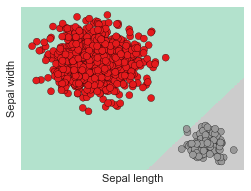

Loss 0.00494445880785


In [112]:
np.random.seed(None)
softreg = SoftmaxRegression(eta=1e-2, l2=1e-5,
                            epochs=300,
                            random_seed=None)
fit_plot(X, Y, fit_classifier=softreg)
print("Loss", softreg.cost_[-1])

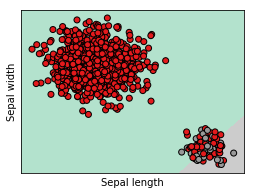

Loss 0.0502641892238


In [14]:
np.random.seed(None)
softreg = SoftmaxRegression(eta=1e-2, l2=1e-5,
                            epochs=200,
                            random_seed=12)
fit_plot(X, Y_pus[5][1], fit_classifier=softreg)
print("Loss", softreg.cost_[-1])

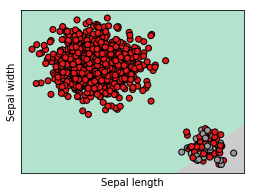

Loss: 0.0431640065768


In [15]:
np.random.seed(None)
pu_softreg = PUSoftmaxRegression(r=1,
                                 minibatches=1,
                                 eta=1e-3, l2=1e-5,
                                 epochs=200,
                                 random_seed=None)
fit_plot(X, Y_pus[5][1], fit_classifier=pu_softreg)
print('Loss:', pu_softreg.cost_[-1])

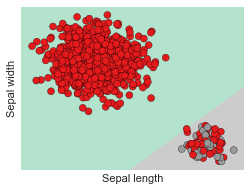

Loss: 0.214861924072


In [154]:
np.random.seed(None)
trans_softreg = TranslatedSoftmaxRegression(translate=(0,-30),
                                            minibatches=10,
                                            eta=1e-3, l2=1e-5,
                                            epochs=200,
                                            random_seed=None)
fit_plot(X, Y_pus[5][1], fit_classifier=trans_softreg)
print('Loss:', trans_softreg.cost_[-1])

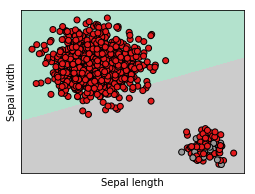

Loss: 0.00132046486867


In [25]:
np.random.seed(None)
asym_softreg = SoftmaxRegression(class_weight=(.0001, 1),
                                 eta=1e-3, l2=1e-5,
                                 epochs=200,
                                 random_seed=None)
fit_plot(X,  Y_pus[8][1], fit_classifier=asym_softreg)
print('Loss:', asym_softreg.cost_[-1])

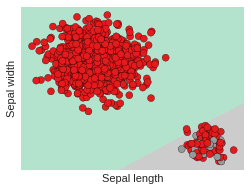

<module 'matplotlib.pyplot' from '/home/jihong/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

In [31]:
np.random.seed(None)
wu_softreg = WeightedUSoftmaxRegression(r_unlabeled=5,
                                        a_unlabeled=0.0001,
                                 eta=1e-3, l2=1e-5,
                                 epochs=200,
                                 random_seed=None)
fit_plot(X,  Y_pus[8][1], fit_classifier=wu_softreg)

Positive (beta=0.0): 800  vs. 800
Positive (beta=0.1): 800  vs. 725
Positive (beta=0.2): 800  vs. 652
Positive (beta=0.30000000000000004): 800  vs. 548
Positive (beta=0.4): 800  vs. 482
Positive (beta=0.5): 800  vs. 401
Positive (beta=0.6000000000000001): 800  vs. 310
Positive (beta=0.7000000000000001): 800  vs. 236
Positive (beta=0.8): 800  vs. 152
Positive (beta=0.9): 800  vs. 87
Positive (beta=1.0): 800  vs. 0


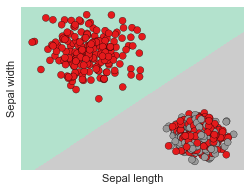

Loss 0.0201533018288


In [200]:
# Number of samples per component
n_samples = 1000
# Percentage of test samples
pct_positive = 0.8
# Generate random sample, two components
random_seed = 0     
X, Y = get_gaussians(n_samples, pct_positive, distance=5, random_seed=random_seed)
betas = np.arange(0., 1+1e-8, 0.1)
Y_pus = get_PU_labels(Y, betas, random_seed=random_seed)
np.random.seed(None)
clsd_softreg = ClassDependentSoftmaxRegression(class_weight=(.1, 1),
                                               eta=1e-2, l2=1e-5,
                                               epochs=200,
                                               random_seed=None)
fit_plot(X, Y_pus[5][1], fit_classifier=clsd_softreg)
print('Loss', clsd_softreg.cost_[-1])

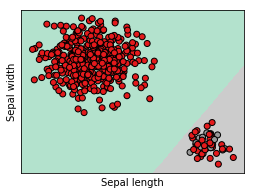

Loss: 0.459707665818
w [[-0.67718241  0.70006757]
 [ 0.4483536  -0.44292837]]
b [-0.95804442  0.95804442]


In [22]:
np.random.seed(None)
selasym_softreg = SelectiveAsymmetricSoftmaxRegression(betas=(0.1, 1),
                                           thresh=(.9, 10, 0.7),
                                           eta=1e-2, l2=1e-5,
                                           epochs=200,
                                           random_seed=None)
fit_plot(X,  Y_pus[6][1], fit_classifier=selasym_softreg)
print('Loss:', selasym_softreg.cost_[-1])
print('w', selasym_softreg.w_)
print('b', selasym_softreg.b_)

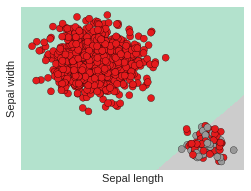

Loss 0.00922981555063
W [[-15.85819143  16.53731214]
 [ 14.02591947 -14.89496307]]
b [-15.04818681  12.45074931]


In [63]:
np.random.seed(None)
# X, Y = get_gaussians(n_samples, pct_positive, random_seed=30)
# Y_pus = get_PU_labels(Y, np.arange(0., 1+1e-8, 0.1), random_seed=30)
ent_softreg = EntropyRegularizedSoftmaxRegression(eta=1e-2, l2=1e-5,
                                                   epochs=200,
                                                   random_seed=None)
fit_plot(X, Y_pus[5][1], fit_classifier=ent_softreg)
print("Loss", ent_softreg.cost_[-1])
print("W", ent_softreg.w_)
print("b", ent_softreg.b_)

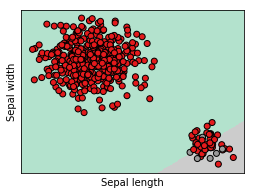

Loss 0.045270503763


In [24]:
np.random.seed(None)
hardb_softreg = HardBootstrappingSoftmaxRegression(betas=(0.1, 1),
                                                   eta=1e-2, l2=1e-5,
                                                   epochs=200,
                                                   random_seed=None)
fit_plot(X, Y_pus[8][1], fit_classifier=hardb_softreg)
print("Loss", hardb_softreg.cost_[-1])

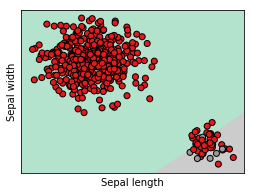

Loss 0.0101791613183


In [25]:
decb_softreg = DecayBootstrappingSoftmaxRegression(betas=(0.1, 1, 0.1),
                                                   eta=1e-2, l2=1e-5,
                                                   epochs=200,
                                                   random_seed=None)
fit_plot(X, Y_pus[8][1], fit_classifier=decb_softreg)
print("Loss", decb_softreg.cost_[-1])

### Softmax vs. Asym. Softmax vs. Selective Asym. Softmax vs. Hard bootstrapping Softmax

In [26]:
import pandas as pd
from sklearn import metrics


X_test, Y_test = get_gaussians(n_samples=500, pct_positive=0.5, random_seed=42)


classifiers = {
    'softreg': SoftmaxRegression(eta=1e-3, l2=1e-5,
                      epochs=200,
                      n_classes=2,
                      random_seed=None),
    'asym_softreg': AsymmetricSoftmaxRegression(betas=(0.1, 1),
                                eta=1e-2, l2=1e-5,
                                epochs=200,
                                n_classes=2,
                                random_seed=None),
    'selasym_softreg': SelectiveAsymmetricSoftmaxRegression(betas=(0.1, 1),
                                                       thresh=(.9, 10, 0.7),
                                                       eta=1e-2,
                                                       l2=1e-5,
                                                       epochs=200,
                                                       n_classes=2,
                                                       random_seed=None),
    'hardb_softreg': HardBootstrappingSoftmaxRegression(betas=(0.1, 1),
                                       eta=1e-2, l2=1e-5,
                                       epochs=200,
                                       n_classes=2,
                                       random_seed=None),
    'decayb_softreg': DecayBootstrappingSoftmaxRegression(betas=(0.5, 10, 0.1),
                                                   eta=1e-2, l2=1e-5,
                                                   epochs=200,
                                                   n_classes=2,
                                                   random_seed=None)
}


n_iters = 10
args_list = []
for it in range(n_iters):
    for pct_positive in [0.01, 0.1, 0.2, 0.5, 0.8]:
        X, Y = get_gaussians(n_samples=500, pct_positive=pct_positive, random_seed=None)
        Y_pus = get_PU_labels(Y, betas=np.arange(0., 1+1e-8, 0.1), random_seed=None)
        for idx in range(len(Y_pus)):
            for name, clsf in classifiers.items():
                args = dict(X=X,
                            Y=Y_pus[idx][1],
                            X_test=X_test,
                            Y_test=Y_test,
                            pct_missing=Y_pus[idx][0],
                            pct_positive=pct_positive,
                            Loss=name,
                            clsf=clsf)
                args_list.append(args)

def fit_classifier(args):
    new_row = {}
    new_row['%missing'] = args['pct_missing']
    new_row['%positive'] = args['pct_positive']
    new_row['Loss'] = args['Loss']
    clsf = args['clsf']
    clsf.fit(args['X'], args['Y'])
    Y_pred = clsf.predict(args['X_test'])
    auc = metrics.roc_auc_score(args['Y_test'], Y_pred)
    new_row['AUC'] = auc
    return new_row

from multiprocessing import Pool
pool = Pool(processes=8)
acc_grid_list = pool.map(fit_classifier, args_list)
acc_grid = pd.DataFrame(acc_grid_list)

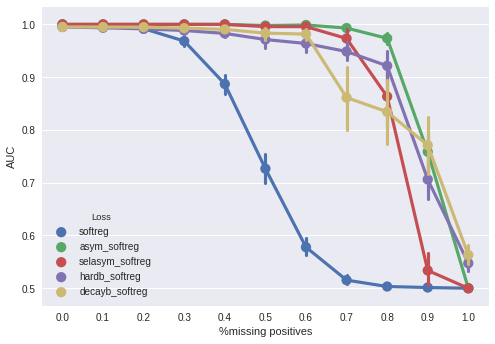

In [27]:
import seaborn as sns
f, ax = plt.subplots(1)

pct_positives = [0.1, 0.2, 0.5, 0.8]
# pct_positives = [0.8]
sns.pointplot(x='%missing', y='AUC', hue='Loss', data=acc_grid[acc_grid['%positive'].isin(pct_positives)], ax=ax)
ax.set_xlabel('%missing positives')
ax.set_ylabel('AUC')

### Asym. Softmax vs. Selective Asym. Softmax

In [28]:
import pandas as pd
from sklearn import metrics


X_test, Y_test = get_gaussians(n_samples=500, pct_positive=0.1, random_seed=42)


betas = [(0.001, 1), (0.01, 1), (0.1, 1), (0.2, 1), (0.5, 1), (1, 1)]

classifiers = [{
    'asym_softreg': AsymmetricSoftmaxRegression(betas=b,
                                             eta=1e-2, l2=1e-5,
                                             epochs=200,
                                             n_classes=2,
                                             random_seed=None),
    'selasym_softreg': SelectiveAsymmetricSoftmaxRegression(betas=b,
                                                         thresh=(.9, 10, .7),
                                                         eta=1e-2, l2=1e-5,
                                                         epochs=200,
                                                         n_classes=2,
                                                         random_seed=None),
    'hardb_softreg': HardBootstrappingSoftmaxRegression(betas=b,
                                       eta=1e-2, l2=1e-5,
                                       epochs=200,
                                       n_classes=2,
                                       random_seed=None)}
    for b in betas]


n_iters = 10
args_list = []
for it in range(n_iters):
    for pct_positive in [0.01, 0.05, 0.1, 0.2, 0.5, 0.8]:
        X, Y = get_gaussians(n_samples=500, pct_positive=pct_positive, random_seed=None)
        Y_pus = get_PU_labels(Y, betas=np.arange(0., 1+1e-8, 0.1), random_seed=None)
        for idx in range(len(Y_pus)): # %missing
            for b, softregs in zip(betas, classifiers):   # beta
                for name, clsf in softregs.items(): # Loss
                    args = dict(X=X,
                            Y=Y_pus[idx][1],
                            X_test=X_test,
                            Y_test=Y_test,
                            pct_missing=Y_pus[idx][0],
                            pct_positive=pct_positive,
                            Loss=name,
                            beta=str(b),
                            clsf=clsf)
                    args_list.append(args)

def fit_classifier(args):
    new_row = {}
    new_row['%missing'] = args['pct_missing']
    new_row['%positive'] = args['pct_positive']
    new_row['Loss'] = args['Loss']
    new_row['beta'] = args['beta']
    clsf = args['clsf']
    clsf.fit(args['X'], args['Y'])
    Y_pred = clsf.predict(args['X_test'])
    auc = metrics.roc_auc_score(args['Y_test'], Y_pred)
    new_row['AUC'] = auc
    return new_row

from multiprocessing import Pool, cpu_count
pool = Pool(processes=cpu_count())
acc_table_list = pool.map(fit_classifier, args_list)
acc_table = pd.DataFrame(acc_table_list)

In [29]:
print(len(acc_table[acc_table['Loss'] == 'asym_softreg']))
print(len(acc_table[acc_table['Loss'] == 'selasym_softreg']))
print(len(acc_table[acc_table['Loss'] == 'hardb_softreg']))

3960
3960
3960


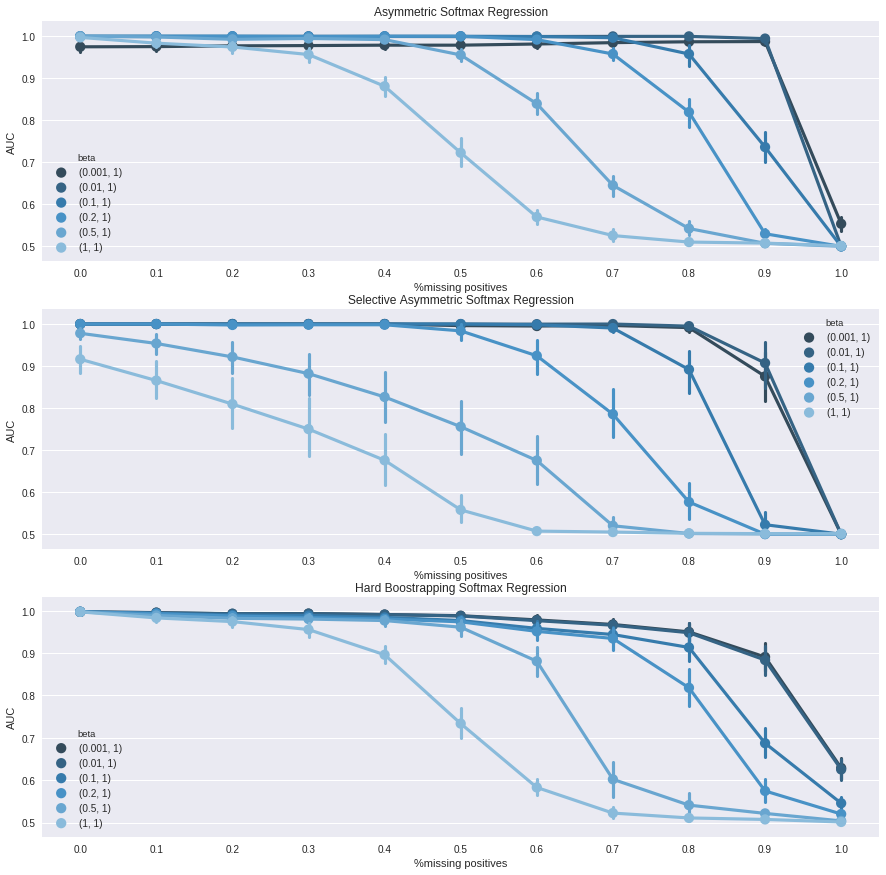

In [30]:
import seaborn as sns

pct_positives = [0.01, 0.05]
pct_positives = [0.1, 0.2, 0.5, 0.8]
# pct_positives = [0.8]
f, ax = plt.subplots(3, figsize=(15, 15))
sns.pointplot(x='%missing', y='AUC', hue='beta', data=acc_table[(acc_table['Loss'] == 'asym_softreg') & (acc_table['%positive'].isin(pct_positives))], palette=sns.color_palette("Blues_d"), ax=ax[0])
ax[0].set_xlabel('%missing positives')
ax[0].set_ylabel('AUC')
ax[0].set_title('Asymmetric Softmax Regression')


sns.pointplot(x='%missing', y='AUC', hue='beta', data=acc_table[(acc_table['Loss'] == 'selasym_softreg') & (acc_table['%positive'].isin(pct_positives))], palette=sns.color_palette("Blues_d"), ax=ax[1])
ax[1].set_xlabel('%missing positives')
ax[1].set_ylabel('AUC')
ax[1].set_title('Selective Asymmetric Softmax Regression')

sns.pointplot(x='%missing', y='AUC', hue='beta', data=acc_table[(acc_table['Loss'] == 'hardb_softreg') & ((acc_table['%positive'].isin(pct_positives)))], palette=sns.color_palette("Blues_d"), ax=ax[2])
ax[2].set_xlabel('%missing positives')
ax[2].set_ylabel('AUC')
ax[2].set_title('Hard Boostrapping Softmax Regression')

### Multiclasses

Positive (beta=0.0): 375  vs. 375
Positive (beta=0.1): 375  vs. 348
Positive (beta=0.2): 375  vs. 304
Positive (beta=0.30000000000000004): 375  vs. 257
Positive (beta=0.4): 375  vs. 230
Positive (beta=0.5): 375  vs. 176
Positive (beta=0.6000000000000001): 375  vs. 148
Positive (beta=0.7000000000000001): 375  vs. 87
Positive (beta=0.8): 375  vs. 64
Positive (beta=0.9): 375  vs. 35
Positive (beta=1.0): 375  vs. 0


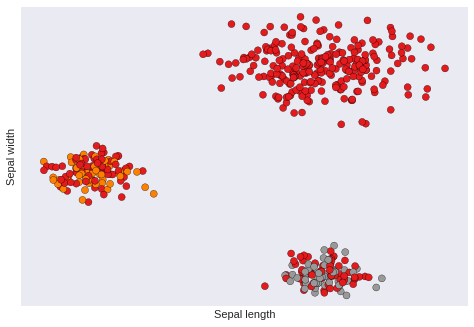

In [31]:
def get_3gaussians(n_samples, pct_positive=0.2, distance=5, random_seed=None):
    np.random.seed(random_seed)
    n_positives = int(n_samples * pct_positive)
    n_positives_1 = int(n_positives / 2)
    n_positives_2 = n_positives - n_positives_1
    n_negatives = n_samples - n_positives
    C = np.array([[.5, 0.], [0., .5]])
    X = np.r_[np.random.randn(n_negatives, 2) + np.array([distance, distance]),
              np.dot(np.random.randn(n_positives_1, 2), C),
              np.dot(np.random.randn(n_positives_1, 2), C) + np.array([+distance, -distance])]
    Y = np.r_[np.zeros(n_negatives), np.ones(n_positives_1), 2 * np.ones(n_positives_2)].astype('int')
    return X, Y
# Number of samples per component
n_samples = 500
# Percentage of test samples
pct_positive = 0.5
# Generate random sample, two components
random_seed = 0     
X, Y = get_3gaussians(n_samples, pct_positive, random_seed=random_seed)
betas = np.arange(0., 1+1e-8, 0.1)
Y_pus = get_PU_labels(Y, betas, random_seed=random_seed)
fit_plot(X, Y_pus[5][1], fit_classifier=False)

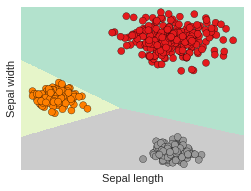

Loss 0.000834750941919


In [32]:
np.random.seed(None)
softreg = SoftmaxRegression(eta=1e-2, l2=1e-5,
                            epochs=300,
                            random_seed=None)
fit_plot(X, Y, fit_classifier=softreg)
print("Loss", softreg.cost_[-1])

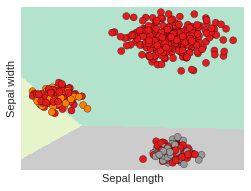

Loss 0.270403371697


In [33]:
np.random.seed(None)
softreg = SoftmaxRegression(eta=1e-3, l2=1e-5,
                            epochs=200,
                            random_seed=12)
fit_plot(X, Y_pus[5][1], fit_classifier=softreg)
print("Loss", softreg.cost_[-1])

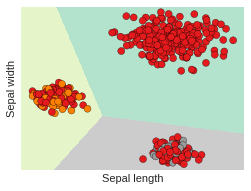

Loss: 0.0499129870512


In [34]:
np.random.seed(None)
asym_softreg = AsymmetricSoftmaxRegression(betas=(0.1, 1, 1),
                                           eta=1e-3, l2=1e-5,
                                           epochs=200,
                                           random_seed=None)
fit_plot(X,  Y_pus[6][1], fit_classifier=asym_softreg)
print('Loss:', asym_softreg.cost_[-1])

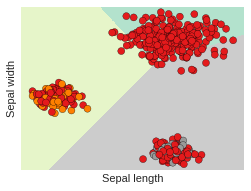

Loss: 0.00559690849305
W [[ 0.00443593 -0.57805464  0.57369537]
 [ 0.36432122  0.09378554 -0.48222604]]


In [35]:
np.random.seed(None)
selasym_softreg = SelectiveAsymmetricSoftmaxRegression(betas=(0.001, 1, 1),
                                                       thresh=(1., 100, 0.8),
                                                       eta=1e-3,
                                                       l2=1e-5,
                                                       epochs=200,
                                                       random_seed=None)
fit_plot(X, Y_pus[6][1], fit_classifier=selasym_softreg)
print('Loss:', selasym_softreg.cost_[-1])
print('W', selasym_softreg.w_)

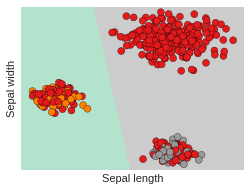

Loss 0.0509595716463
W [[-14.0246937  -14.28914894 -13.69893284]
 [ -5.44925517  -5.42752422  -5.36045354]]
b [-5.2550399  -3.7157877  -5.14379566]


In [36]:
np.random.seed(None)
ent_softreg = EntropyRegularizedSoftmaxRegression(eta=1e-3, l2=1e-5,
                                                   epochs=200,
                                                   random_seed=None)
fit_plot(X, Y_pus[5][1], fit_classifier=ent_softreg)
print("Loss", ent_softreg.cost_[-1])
print("W", ent_softreg.w_)
print("b", ent_softreg.b_)

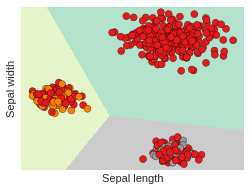

Loss 0.0632025101645


In [37]:
np.random.seed(None)
hardb_softreg = HardBootstrappingSoftmaxRegression(betas=(0.1, 1, 1),
                                                   eta=1e-3, l2=1e-5,
                                                   epochs=300,
                                                   random_seed=None)
fit_plot(X, Y_pus[6][1], fit_classifier=hardb_softreg)
print("Loss", hardb_softreg.cost_[-1])

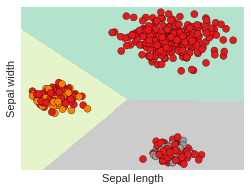

Loss 0.00520384809942


In [38]:
decb_softreg = DecayBootstrappingSoftmaxRegression(betas=(0.5, 10, 0.1),
                                                   eta=1e-3, l2=1e-5,
                                                   epochs=200,
                                                   random_seed=None)
fit_plot(X, Y_pus[6][1], fit_classifier=decb_softreg)
print("Loss", decb_softreg.cost_[-1])

In [39]:
import pandas as pd
from sklearn import metrics


X_test, Y_test = get_3gaussians(n_samples=500, pct_positive=0.5, random_seed=42)


classifiers = {
    'softreg': SoftmaxRegression(eta=1e-3, l2=1e-5,
                      epochs=200,
                      n_classes=3,
                      random_seed=None),
    'asym_softreg': AsymmetricSoftmaxRegression(betas=(0.1, 1, 1),
                                eta=1e-3, l2=1e-5,
                                epochs=200,
                                n_classes=3,
                                random_seed=None),
    'selasym_softreg': SelectiveAsymmetricSoftmaxRegression(betas=(0.1, 1, 1),
                                                       thresh=(.9, 100, 0.7),
                                                       eta=1e-3, l2=1e-5,
                                                       epochs=200,
                                                       n_classes=3,
                                                       random_seed=None),
    'hardb_softreg': HardBootstrappingSoftmaxRegression(betas=(0.1, 1, 1),
                                       eta=1e-3, l2=1e-5,
                                       epochs=200,
                                       n_classes=3,
                                       random_seed=None),
    'decb_softreg': DecayBootstrappingSoftmaxRegression(betas=(0.5, 10, 0.1),
                                                   eta=1e-3, l2=1e-5,
                                                   epochs=200,
                                                   n_classes=3,
                                                   random_seed=None)
}

acc_grid = pd.DataFrame(columns=['%missing', 'softreg',
                                 'asym_softreg', 'selasym_softreg', 'hardb_softreg'])
n_iters = 10
args_list = []
for it in range(n_iters):
    for pct_positive in [0.1, 0.2, 0.5, 0.8]:
        X, Y = get_3gaussians(n_samples=500, pct_positive=pct_positive, random_seed=None)
        Y_pus = get_PU_labels(Y, betas=np.arange(0., 1+1e-8, 0.1), random_seed=None)
        for idx in range(len(Y_pus)):
            for name, clsf in classifiers.items():
                args = dict(X=X,
                            Y=Y_pus[idx][1],
                            X_test=X_test,
                            Y_test=Y_test,
                            pct_missing=Y_pus[idx][0],
                            pct_positive=pct_positive,
                            Loss=name,
                            clsf=clsf)
                args_list.append(args)

def fit_classifier(args):
    new_row = {}
    new_row['%missing'] = args['pct_missing']
    new_row['%positive'] = args['pct_positive']
    new_row['Loss'] = args['Loss']
    clsf = args['clsf']
    clsf.fit(args['X'], args['Y'])
    # evaluate
    Y_pred = clsf.predict(args['X_test'])
    Y_test = args['Y_test']
    aucs = []
    for i in range(3):
        y_test = Y_test == i
        y_pred = Y_pred == i
        auc = metrics.roc_auc_score(y_test, y_pred)
        aucs.append(auc)
    new_row['AUC'] = np.mean(aucs)
    return new_row

from multiprocessing import Pool
pool = Pool(processes=8)
acc_grid_list = pool.map(fit_classifier, args_list)
acc_grid = pd.DataFrame(acc_grid_list)

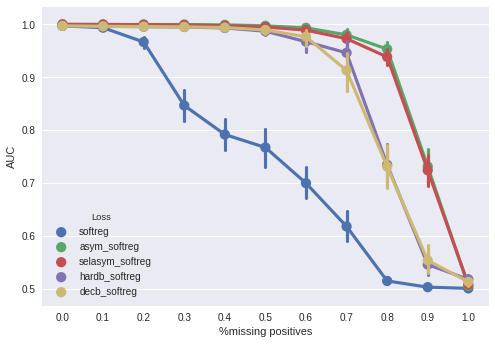

In [40]:
import seaborn as sns
f, ax = plt.subplots(1)

pct_positives = [0.1, 0.2, 0.5, 0.8]
# pct_positives = [0.8]
sns.pointplot(x='%missing', y='AUC', hue='Loss', data=acc_grid[acc_grid['%positive'].isin(pct_positives)], ax=ax)
ax.set_xlabel('%missing positives')
ax.set_ylabel('AUC')

In [41]:
import pandas as pd
from sklearn import metrics


X_test, Y_test = get_3gaussians(n_samples=500, pct_positive=0.1, random_seed=42)


betas = [(0.001, 1, 1), (0.01, 1, 1), (0.1, 1, 1), (0.2, 1, 1), (0.5, 1, 1), (1, 1, 1)]

classifiers = [{
    'asym_softreg': AsymmetricSoftmaxRegression(betas=b,
                                             eta=1e-3, l2=1e-5,
                                             epochs=200,
                                             n_classes=3,
                                             random_seed=None),
    'selasym_softreg': SelectiveAsymmetricSoftmaxRegression(betas=b,
                                                         thresh=(.9, 10, .7),
                                                         eta=1e-3, l2=1e-5,
                                                         epochs=200,
                                                         n_classes=3,
                                                         random_seed=None),
    'hardb_softreg': HardBootstrappingSoftmaxRegression(betas=b,
                                       eta=1e-3, l2=1e-5,
                                       epochs=200,
                                       n_classes=3,
                                       random_seed=None)}
    for b in betas]


n_iters = 10
args_list = []
for it in range(n_iters):
    for pct_positive in [0.1, 0.2, 0.5, 0.8]:
        X, Y = get_3gaussians(n_samples=500, pct_positive=pct_positive, random_seed=None)
        Y_pus = get_PU_labels(Y, betas=np.arange(0., 1+1e-8, 0.1), random_seed=None)
        for idx in range(len(Y_pus)): # %missing
            for b, softregs in zip(betas, classifiers):   # beta
                for name, clsf in softregs.items(): # Loss
                    args = dict(X=X,
                            Y=Y_pus[idx][1],
                            X_test=X_test,
                            Y_test=Y_test,
                            pct_missing=Y_pus[idx][0],
                            pct_positive=pct_positive,
                            Loss=name,
                            beta=str(b),
                            clsf=clsf)
                    args_list.append(args)

def fit_classifier(args):
    new_row = {}
    new_row['%missing'] = args['pct_missing']
    new_row['%positive'] = args['pct_positive']
    new_row['Loss'] = args['Loss']
    new_row['beta'] = args['beta']
    clsf = args['clsf']
    clsf.fit(args['X'], args['Y'])
    # evaluate
    Y_pred = clsf.predict(args['X_test'])
    Y_test = args['Y_test']
    aucs = []
    for i in range(3):
        y_test = Y_test == i
        y_pred = Y_pred == i
        auc = metrics.roc_auc_score(y_test, y_pred)
        aucs.append(auc)
    new_row['AUC'] = np.mean(aucs)
    return new_row

from multiprocessing import Pool, cpu_count
pool = Pool(processes=cpu_count())
acc_table_list = pool.map(fit_classifier, args_list)
acc_table = pd.DataFrame(acc_table_list)

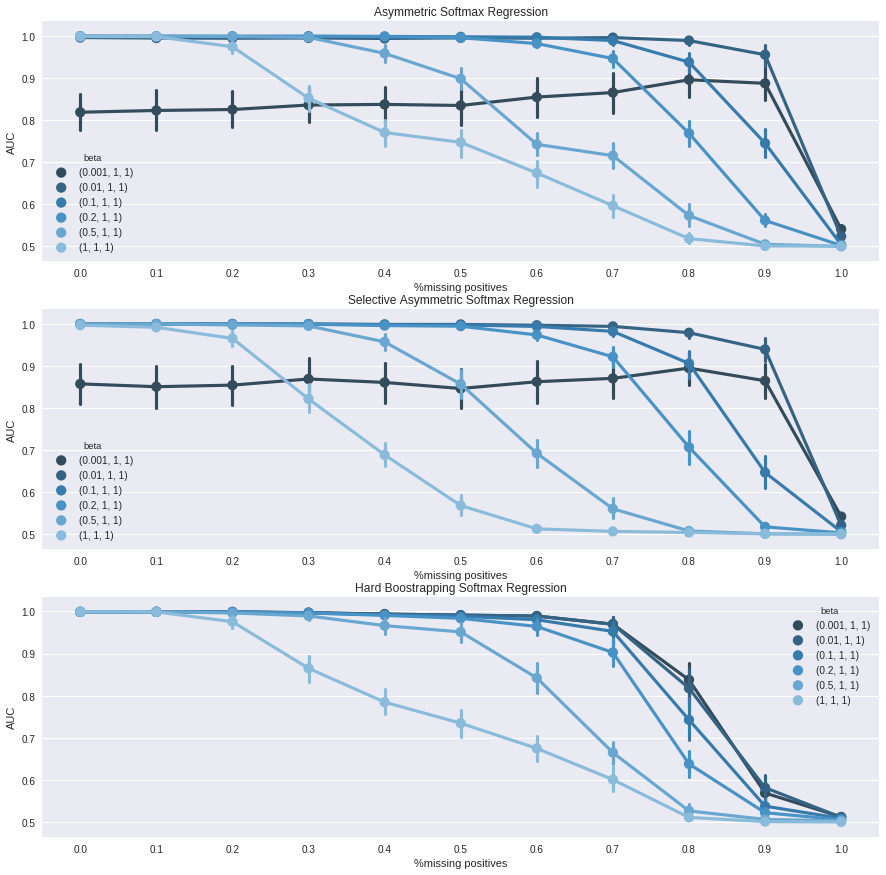

In [42]:
import seaborn as sns

pct_positives = [0.01, 0.05]
pct_positives = [0.1, 0.2, 0.5, 0.8]
# pct_positives = [0.8]
f, ax = plt.subplots(3, figsize=(15, 15))
sns.pointplot(x='%missing', y='AUC', hue='beta', data=acc_table[(acc_table['Loss'] == 'asym_softreg') & (acc_table['%positive'].isin(pct_positives))], palette=sns.color_palette("Blues_d"), ax=ax[0])
ax[0].set_xlabel('%missing positives')
ax[0].set_ylabel('AUC')
ax[0].set_title('Asymmetric Softmax Regression')


sns.pointplot(x='%missing', y='AUC', hue='beta', data=acc_table[(acc_table['Loss'] == 'selasym_softreg') & (acc_table['%positive'].isin(pct_positives))], palette=sns.color_palette("Blues_d"), ax=ax[1])
ax[1].set_xlabel('%missing positives')
ax[1].set_ylabel('AUC')
ax[1].set_title('Selective Asymmetric Softmax Regression')

sns.pointplot(x='%missing', y='AUC', hue='beta', data=acc_table[(acc_table['Loss'] == 'hardb_softreg') & ((acc_table['%positive'].isin(pct_positives)))], palette=sns.color_palette("Blues_d"), ax=ax[2])
ax[2].set_xlabel('%missing positives')
ax[2].set_ylabel('AUC')
ax[2].set_title('Hard Boostrapping Softmax Regression')